<a href="https://colab.research.google.com/github/n2cholas/dsc-workshops/blob/master/JAX_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# JAX Demo



Here's a brief overview of some key JAX functions, followed by an end-to-end logistic regression example. 

Created 2 July 2020 for the University of Waterloo's Data Science Club's Introduction to JAX workshop. Slides available [here](https://docs.google.com/presentation/d/11dPbvZVsHBzSpbA227RMZ7O_Cl-Yc1UTtEAwdKa2tTc/edit?usp=sharing). The recording will be made available on [this channel](https://www.youtube.com/channel/UCknY88pglf2xz_S72WHIDxg).

## Set Up

Run this cell if you are using a TPU runtime.

In [1]:
# Make sure the Colab Runtime is set to Accelerator: TPU.
import requests
import os
if 'TPU_DRIVER_MODE' not in globals():
  url = 'http://' + os.environ['COLAB_TPU_ADDR'].split(':')[0] + ':8475/requestversion/tpu_driver0.1-dev20191206'
  resp = requests.post(url)
  TPU_DRIVER_MODE = 1

# The following is required to use TPU Driver as JAX's backend.
from jax.config import config
config.FLAGS.jax_xla_backend = "tpu_driver"
config.FLAGS.jax_backend_target = "grpc://" + os.environ['COLAB_TPU_ADDR']
print(config.FLAGS.jax_backend_target)

grpc://10.4.236.234:8470


This code let's you conveniently load MNIST from torchvision.

In [2]:
import os
import torch
import torchvision
import numpy as np

def MNIST(train=False):
    transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,)),
        lambda x: x.numpy().squeeze(),
    ])
    return torchvision.datasets.MNIST(os.getcwd(), train=train, 
                                     download=True, 
                                     transform=transform)

class DataLoader(torch.utils.data.DataLoader):
    def __init__(self, dataset, batch_size=1, shuffle=False, sampler=None,
                 batch_sampler=None, num_workers=0, drop_last=False, timeout=0,
                 worker_init_fn=None):
        super().__init__(dataset,
                         batch_size=batch_size,
                         shuffle=shuffle,
                         sampler=sampler,
                         batch_sampler=batch_sampler,
                         num_workers=num_workers,
                         collate_fn=collate_fn,
                         pin_memory=False,  # pinning doesn't affect jax arrays (right?)
                         drop_last=drop_last,
                         timeout=timeout,
                         worker_init_fn=worker_init_fn)


def collate_fn(batch):
    if isinstance(batch[0], jnp.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple, list)):
        return type(batch[0])(collate_fn(samples) for samples in zip(*batch))
    elif isinstance(batch[0], dict):
        return {k: collate_fn([d[k] for d in batch]) for k in batch[0]}
    else:
        return np.asarray(batch)

# Mini-Demo

In this section, we look at how JAX's function transformations work.

In [3]:
import jax
from jax import grad, jit, vmap, pmap, value_and_grad
import jax.numpy as jnp

def cool_fn(a, b, x):
    return a*jnp.dot(b, x)

a = jnp.array(3.)
b = jnp.array([3., 2., 1.])
x = jnp.array([4., 4., 4.])

In [4]:
cool_fn(a, b, x)

DeviceArray(72., dtype=float32)

## grad

grad computes the gradient with respect to one or more of the input arguments. By default, it computes the gradient with respect to the first argument.

In [5]:
grad(cool_fn)(a, b, x)

DeviceArray(24., dtype=float32)

We can also compute the gradient with respect to multiple arguments, such as `b` and `x` below.

In [6]:
grad(cool_fn, argnums=(1, 2))(a, b, x)

(DeviceArray([12., 12., 12.], dtype=float32),
 DeviceArray([9., 6., 3.], dtype=float32))

We can take a take a higher order derivate by composing the `grad` functions:

In [7]:
grad(grad(grad(grad(cool_fn))))(a, b, x)

DeviceArray(0., dtype=float32)

It's often useful to get both the value and the gradient:

In [8]:
value_and_grad(cool_fn)(a, b, x)

(DeviceArray(72., dtype=float32), DeviceArray(24., dtype=float32))

## vmap

Vectorized map allows you to add a batch dimension to one or more arguments:

In [9]:
x2 = jnp.array([[1., 1., 1.],
               [2., 3., 1.],
               [3., 4., 4.],
               [4., 5., 2.]])

`in_axes` is a tuple representing which axis will be batched for each argument. Here, we indicate only the third argument will be batched, and it will be batched at the 0th dimension.

In [10]:
vmap(cool_fn, in_axes=(None, None, 0))(a, b, x2)

DeviceArray([18., 39., 63., 72.], dtype=float32)

We can arbitrarily compute `grad` and `vmap`:

In [11]:
vmap(grad(cool_fn), in_axes=(None, None, 0))(a, b, x2)

DeviceArray([ 6., 13., 21., 24.], dtype=float32)

## jit

`jit` (just in time compilation) compiles your python code via XLA to optimize it and remove python overhead:

In [12]:
jit(cool_fn)(a, b, x)

DeviceArray(72., dtype=float32)

As with all the function transformations, we can compute them:

In [13]:
jit(vmap(grad(cool_fn), in_axes=(None, None, 0)))(a, b, x2)

DeviceArray([ 6., 13., 21., 24.], dtype=float32)

## pmap

Parallel map let's you execute a function on a homogenous set of devices (e.g. multiple TPUs or multiple GPUs).

In [14]:
jax.local_devices()

[TpuDevice(id=0, host_id=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, host_id=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=2, host_id=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=3, host_id=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=4, host_id=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=5, host_id=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=6, host_id=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=7, host_id=0, coords=(0,0,0), core_on_chip=0)]

In [15]:
a = jnp.ones(8)
a

DeviceArray([1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

The parallelized dimension must have elements less than or equal to the number of devices. The input will be split along the parallelized dimension(s), the computation will happen on each device, then the results are concatenated:

In [16]:
pmap(cool_fn, in_axes=(0, None, None))(a, b, x)

ShardedDeviceArray([24., 24., 24., 24., 24., 24., 24., 24.], dtype=float32)

## randomness

In JAX, you must use an explict PRNG key. Check out https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html for more details

In numpy, you're used to generating random numbers via an implicit random key:

In [17]:
import numpy as np

In [18]:
np.random.rand(5)

array([0.18557401, 0.11987591, 0.27819761, 0.43926921, 0.05016992])

In JAX, that's explicit:

In [19]:
prng = jax.random.PRNGKey(0)

You generally want to use the key once, so I typically split the key before using it, so I have a current key and a key that I will use in the future:

In [20]:
prng, cur = jax.random.split(prng, 2)

In [21]:
jax.random.uniform(cur, (5,))
# use prng for other things

DeviceArray([0.07239354, 0.02032685, 0.9796876 , 0.87867916, 0.16457272],            dtype=float32)

# Logistic Regression in JAX

We'll write a simple training loop to train a logistic regression model with minibatch gradient descent

In [22]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

We load MNIST, a dataset of 60000 handwritten digits, using `torchvision`. We just need to augment our dataloader to return numpy arrays instead of torch tensors (in the set up code at the top).

In [23]:
dataset = MNIST(train=True)
dataloader = DataLoader(dataset, batch_size=128, num_workers=4)

5


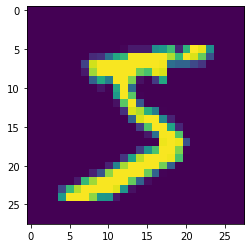

In [24]:
image, label = dataset[0]
plt.imshow(image)
print(label)

We first create our parameters, our weight matrix `W` and our bias `b`. We only use our RNG once, so we don't split it.

In [25]:
rng = jax.random.PRNGKey(0)
W = jax.random.uniform(rng, (28*28, 10))
b = jnp.zeros(10)
params = (W, b)

In order to make a prediction, we define an `apply` function. We use a `log_softmax` instead of a softmax for numerical stability.

In [26]:
def apply(params, image):
    W, b = params
    return jax.nn.log_softmax(W.T @ image.flatten() + b)

In [27]:
jnp.exp(apply(params, image))  # represents the probability of each class

DeviceArray([2.15396110e-08, 2.32523686e-04, 7.38948316e-08,
             1.87424382e-11, 3.16452235e-02, 9.64966595e-01,
             5.38649192e-06, 4.69302108e-09, 3.14939930e-03,
             1.00649586e-07], dtype=float32)

We want to feed in batches of images to our apply function, so let's use vmap. The same parameters are used for all the input images and our batch dimension is at the front, hence `in_axes=(None, 0)`.

In [28]:
batch_apply = jax.vmap(apply, in_axes=(None, 0))

In [29]:
images, labels = next(iter(dataloader))
logits = batch_apply(params, images)
logits.shape

(128, 10)

As we expect, we get our `log_softmax` vector of size 10 for all 128 elements.

Next, we define our cross entropy loss function. Below is the definition for a single sample:

$$ \mathcal L(\hat y, y) = - \sum_{i=1}^{10} y_i \log \hat y_i $$

We write it for the entire batch, since it's simple enough without vmap. We return the average over the batch:

In [30]:
def cross_entropy_loss(logits, labels):
    return -(jax.nn.one_hot(labels, 10) * logits).sum(-1).mean()

In [31]:
cross_entropy_loss(logits, labels)

DeviceArray(11.61635, dtype=float32)

Now, we define the entire loss, which, given parameters and a batch of data, will return the average loss for that batch and the logits (which will be useful to compute accuracy):

In [32]:
def loss_fn(params, batch):
    images, labels = batch
    logits = batch_apply(params, images)
    return cross_entropy_loss(logits, labels), logits

In [33]:
loss, logits = loss_fn(params, (images, labels))
print(f'Loss: {loss:.4f}, Logits Shape: {logits.shape}')

Loss: 11.6164, Logits Shape: (128, 10)


We also define accuracy, which is our metric of interest:

In [34]:
def accuracy(logits, labels):
    return (logits.argmax(-1) == labels).mean()

In [35]:
accuracy(logits, labels)

DeviceArray(0.1171875, dtype=float32)

When we fit our parameters to our data, we use stochastic gradient descent (SGD). It's expressed as follows for a single parameter (e.g. `W`):

In [36]:
def sgd_step(param, grad, lr=0.01):
    return param - lr * grad

We know have all the tools we need to write a single train step:

In [37]:
@jax.jit  # compile the top level function, not each individual function
def train_step(params, batch):
    # has_aux=True is required because we return our loss (what we're differentiating)
    # w.r.t, as well as our logits
    (loss, logits), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, batch)
    # In JAX, any nested structure of dicts, tuples, and lists containing jax
    # arrays is called a PyTree. Multimap applies the function to all the arrays
    # and returns a PyTree of the same structure.
    new_params = jax.tree_multimap(sgd_step, params, grads)
    acc = accuracy(logits, batch[1])
    return new_params, (loss, acc)

We can now train our model (we'll just train for 300 steps for now)

In [38]:
for i, batch in enumerate(dataloader):
    params, (loss, acc) = train_step(params, batch)
    if i % 10 == 0:
        print(f'Iter: {i:3d}  Loss: {loss:.4f}, Accuracy: {acc:.4f}')
    if i > 300:
        break

Iter:   0  Loss: 11.6164, Accuracy: 0.1172
Iter:  10  Loss: 8.5104, Accuracy: 0.0859
Iter:  20  Loss: 6.2342, Accuracy: 0.2266
Iter:  30  Loss: 5.3381, Accuracy: 0.2422
Iter:  40  Loss: 4.6509, Accuracy: 0.2891
Iter:  50  Loss: 4.2726, Accuracy: 0.4062
Iter:  60  Loss: 3.9557, Accuracy: 0.3984
Iter:  70  Loss: 2.9911, Accuracy: 0.4531
Iter:  80  Loss: 3.2631, Accuracy: 0.4688
Iter:  90  Loss: 3.0934, Accuracy: 0.4141
Iter: 100  Loss: 2.2155, Accuracy: 0.6172
Iter: 110  Loss: 2.6738, Accuracy: 0.5312
Iter: 120  Loss: 2.3034, Accuracy: 0.5469
Iter: 130  Loss: 2.6763, Accuracy: 0.5625
Iter: 140  Loss: 2.0505, Accuracy: 0.6250
Iter: 150  Loss: 1.9659, Accuracy: 0.6562
Iter: 160  Loss: 2.3841, Accuracy: 0.5469
Iter: 170  Loss: 1.3181, Accuracy: 0.7188
Iter: 180  Loss: 1.6405, Accuracy: 0.6250
Iter: 190  Loss: 1.8172, Accuracy: 0.6875
Iter: 200  Loss: 1.9610, Accuracy: 0.6484
Iter: 210  Loss: 2.1923, Accuracy: 0.5859
Iter: 220  Loss: 1.4158, Accuracy: 0.6875
Iter: 230  Loss: 1.3246, Accuracy

Nice! Our loss is going down and accuracy going up. Let's see how well our (partially) trained model performs an example:

Prediction: 5  Label: 5


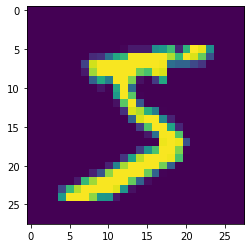

In [39]:
image, label = dataset[0]

pred = apply(params, image).argmax()
plt.imshow(image)
print(f'Prediction: {pred}  Label: {label}')

You can extend this example by making use of all the TPU cores instead of just one by incorporating `pmap`. There's a guide here: https://github.com/google/jax/blob/master/cloud_tpu_colabs/Pmap_Cookbook.ipynb. 

Check out https://github.com/google/jax/ for more complete examples. 